## Housing Affordability

##### Original Datasets:
###### Zillow "Housing Value Index All Homes Time Series Smoothed Seasonally Adjusted"
###### https://www.zillow.com/research/data/
###### USDA "Unemployment and median household income for the U.S., States, and counties, 2000-2021" 
###### https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/
###### US Census "Annual County Resident Population Estimates by Age, Sex, Race, and Hispanic Origin: April 1, 2020 to July 1, 2021"
###### https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/asrh/cc-est2021-agesex-all.csv



Load in libraries

In [ ]:
import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt

import sklearn


In [ ]:
!pip install colorspacious
from colorspacious import cspace_converter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download and read in USDA employment and income CSV to dataframe

In [ ]:
# The first 3 rows are source information, so header index set to start at row 4.
unemployment = pd.read_excel("https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.xlsx?v=7156", "Unemployment Med HH Income", header = 4)


In [ ]:
# Shape of the dataframe
print("Shape: "+ str(unemployment.shape))
# Preview
unemployment.head()

Shape: (3277, 96)


,FIPS_code,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,...,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Civilian_labor_force_2021,Employed_2021,Unemployed_2021,Unemployment_rate_2021,Median_Household_Income_2020,Med_HH_Income_Percent_of_State_Total_2020
0,0,US,United States,NaN,NaN,NaN,142601576.0,136904853.0,5696723.0,3.994853,...,161207103.0,148183367.0,13023736.0,8.078885,161758337.0,153099687.0,8658650.0,5.352831,67340.0,NaN
1,1000,AL,Alabama,NaN,NaN,NaN,2147173.0,2047731.0,99442.0,4.600000,...,2268309.0,2121149.0,147160.0,6.500000,2246993.0,2169721.0,77272.0,3.400000,53958.0,100.000000
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,21861.0,20971.0,890.0,4.100000,...,26405.0,24985.0,1420.0,5.400000,26341.0,25599.0,742.0,2.800000,67565.0,125.217762
3,1003,AL,"Baldwin County, AL",3.0,2.0,1.0,69979.0,67370.0,2609.0,3.700000,...,98910.0,92751.0,6159.0,6.200000,99427.0,96481.0,2946.0,3.000000,71135.0,131.834019
4,1005,AL,"Barbour County, AL",6.0,6.0,0.0,11449.0,10812.0,637.0,5.600000,...,8680.0,8004.0,676.0,7.800000,8197.0,7728.0,469.0,5.700000,38866.0,72.030097


Save nationwide stats for later, then remove the statewide and nationwide rows 

In [ ]:
# Nationwide Stats
US_LF = unemployment.iloc[0]["Civilian_labor_force_2021"]
US_MHI = unemployment.iloc[0]["Median_Household_Income_2020"]

# Check the "Rural_urban_continuum_code_2013" column for rows with null values.
unemployment = unemployment.loc[pd.notna(unemployment['Rural_urban_continuum_code_2013'])]

Standardize FIPS code

In [ ]:
# Use lambda function to format code to 5 digits
unemployment.loc[:, "FIPS_code"]=unemployment["FIPS_code"].apply(lambda x: '{0:0>5}'.format(x))

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Set as new income dataframe with only the relevant columns.

In [ ]:
unemployment = unemployment[["FIPS_code", "Area_name", "Civilian_labor_force_2021", "Median_Household_Income_2020", "Rural_urban_continuum_code_2013"]]
unemployment.head()


,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013
2,01001,"Autauga County, AL",26341.0,67565.0,2.0
3,01003,"Baldwin County, AL",99427.0,71135.0,3.0
4,01005,"Barbour County, AL",8197.0,38866.0,6.0
5,01007,"Bibb County, AL",8560.0,50907.0,1.0
6,01009,"Blount County, AL",25127.0,55203.0,1.0


Load Zillow Housing Value Index

In [ ]:
# Download and read CSV
zhvi = pd.read_csv("https://files.zillowstatic.com/research/public_csvs/zhvi/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1670291347")

Set relevant columns to new price dataframe and drop entries with no price data

In [ ]:
# Set most recent column date name
mostrecentZHVI = "2022-12-31"

# Convert State and Municipal FIPS into single FIPS code. Format as 5 digits
zhvi["FIPS"] = zhvi["StateCodeFIPS"]*1000 + zhvi["MunicipalCodeFIPS"]
zhvi["FIPS"] = zhvi["FIPS"].apply(lambda x: '{0:0>5}'.format(x))

# Preview
zhvi.head()
# Only FIPS code, Name, Most Recent Price 
zhvi = zhvi[["FIPS", "RegionName", mostrecentZHVI]]
# Drop null rows
zhvi = zhvi.dropna(subset=[mostrecentZHVI])
zhvi.head()

,FIPS,RegionName,2022-12-31
0,06037,Los Angeles County,845596.0
1,17031,Cook County,312317.0
2,48201,Harris County,289591.0
3,04013,Maricopa County,451699.0
4,06073,San Diego County,874095.0


Join unemployment and ZHVI dataframes on the FIPS code column

In [ ]:
merged1 = pd.merge(left=unemployment, right=zhvi, left_on='FIPS_code', right_on='FIPS')
merged1.head()

,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013,FIPS,RegionName,2022-12-31
0,01001,"Autauga County, AL",26341.0,67565.0,2.0,01001,Autauga County,247745.0
1,01003,"Baldwin County, AL",99427.0,71135.0,3.0,01003,Baldwin County,378538.0
2,01005,"Barbour County, AL",8197.0,38866.0,6.0,01005,Barbour County,137713.0
3,01007,"Bibb County, AL",8560.0,50907.0,1.0,01007,Bibb County,183821.0
4,01009,"Blount County, AL",25127.0,55203.0,1.0,01009,Blount County,265515.0


Load population data

In [ ]:
pop = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/asrh/cc-est2021-agesex-all.csv", encoding='latin-1')
# Keep only the entries for the most recent year "3"
pop = pop.loc[pop['YEAR'] == 3]
# Preview
pop.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
2,50,1,1,Alabama,Autauga County,3,59095,28733,30362,3388,...,1065,1154,490,664,896,352,544,39.3,38.3,40.3
5,50,1,3,Alabama,Baldwin County,3,239294,116422,122872,12252,...,5091,5728,2619,3109,4232,1775,2457,44.0,42.8,45.0
8,50,1,5,Alabama,Barbour County,3,24964,13305,11659,1307,...,567,549,231,318,477,157,320,41.2,39.3,44.2
11,50,1,7,Alabama,Bibb County,3,22477,12134,10343,1180,...,402,460,190,270,359,118,241,40.3,38.7,42.8
14,50,1,9,Alabama,Blount County,3,59041,29407,29634,3433,...,1177,1270,567,703,1048,394,654,41.2,40.5,41.9


Reformat FIPS code

In [ ]:
pop["FIPS2"] = pop["STATE"]*1000 + pop["COUNTY"]
pop["FIPS2"] = pop["FIPS2"].apply(lambda x: '{0:0>5}'.format(x)) 

In [ ]:
pop = pop[["POPESTIMATE", "FIPS2"]]
pop.head()


,POPESTIMATE,FIPS2
2,59095,01001
5,239294,01003
8,24964,01005
11,22477,01007
14,59041,01009


Merge population with previous dataframe

In [ ]:
merged2=pd.merge(left=merged1, right=pop, left_on='FIPS_code', right_on='FIPS2')
merged2.head()

,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013,FIPS,RegionName,2022-12-31,POPESTIMATE,FIPS2
0,01001,"Autauga County, AL",26341.0,67565.0,2.0,01001,Autauga County,247745.0,59095,01001
1,01003,"Baldwin County, AL",99427.0,71135.0,3.0,01003,Baldwin County,378538.0,239294,01003
2,01005,"Barbour County, AL",8197.0,38866.0,6.0,01005,Barbour County,137713.0,24964,01005
3,01007,"Bibb County, AL",8560.0,50907.0,1.0,01007,Bibb County,183821.0,22477,01007
4,01009,"Blount County, AL",25127.0,55203.0,1.0,01009,Blount County,265515.0,59041,01009


Calculate Price to Income Ratio

In [ ]:
PIR = "Price_Income_Ratio"
merged2[PIR] = merged2[mostrecentZHVI] / merged2["Median_Household_Income_2020"]

Rename and rearrange columns

In [ ]:
merged2.rename(columns = {'Civilian_labor_force_2021':'Labor_Force', 'Median_Household_Income_2020':'Income', mostrecentZHVI:"House_Price", 'POPESTIMATE':'Population', 'Rural_urban_continuum_code_2013':'Rural_urban'}, inplace = True)
merged2 = merged2[["FIPS_code", "Area_name", PIR, "House_Price", "Income", "Labor_Force", "Population", "Rural_urban"]]


Examine and Export

In [ ]:
merged2.head()
merged2.to_csv('merged.csv', encoding='utf-8', index=False)

Calculate mean, standard deviation, percentiles, min/max

Set as new dataframe and export

In [ ]:
#Housing Price
HP_mean = np.mean(merged2['House_Price'])
HP_SD = np.std(merged2['House_Price'])
HP_min = merged2['House_Price'].quantile(q=0)
HP_25 = merged2['House_Price'].quantile(q=0.25)
HP_50 = merged2['House_Price'].quantile(q=0.50)
HP_75 = merged2['House_Price'].quantile(q=0.75)
HP_max = merged2['House_Price'].quantile(q=1)

#Median Income
INC_mean = np.mean(merged2['Income'])
INC_SD = np.std(merged2['Income'])
INC_min = merged2['Income'].quantile(q=0)
INC_25 = merged2['Income'].quantile(q=0.25)
INC_50 = merged2['Income'].quantile(q=0.50)
INC_75 = merged2['Income'].quantile(q=0.75)
INC_max = merged2['Income'].quantile(q=1)

#Price to Income Ratio
PIR_mean = np.mean(merged2[PIR])
PIR_SD = np.std(merged2[PIR])
PIR_min = merged2[PIR].quantile(q=0)
PIR_25 = merged2[PIR].quantile(q=0.25)
PIR_50 = merged2[PIR].quantile(q=0.50)
PIR_75 = merged2[PIR].quantile(q=0.75)
PIR_max = merged2[PIR].quantile(q=1)


In [ ]:
#Merge all stats into new statsdf dataframe with headers
statsdf = pd.DataFrame(columns=["Mean", "St_Dev", "Min", "25%", "Median", "75%", "Max"])
statsdf.loc['Price_Income_Ratio'] = [PIR_mean, PIR_SD, PIR_min, PIR_25, PIR_50, PIR_75, PIR_max]
statsdf.loc['House_Price'] = [HP_mean, HP_SD, HP_min, HP_25, HP_50, HP_75, HP_max]
statsdf.loc['Income'] = [INC_mean, INC_SD, INC_min, INC_25, INC_50, INC_75, INC_max]
# Preview
statsdf

,Mean,St_Dev,Min,25%,Median,75%,Max
Price_Income_Ratio,4.119392,1.883804,1.087423,2.920106,3.692877,4.745922,2.437296e+01
House_Price,249393.265845,168165.991808,39840.000000,146302.000000,203040.500000,302350.750000,2.332809e+06
Income,58018.909507,14684.018108,26866.000000,48286.750000,55627.000000,64502.750000,1.603050e+05


In [ ]:
# Export
statsdf.to_csv('stats.csv', index=False)

Create Large Color-Coded Scatterplot with Highlighted Counties

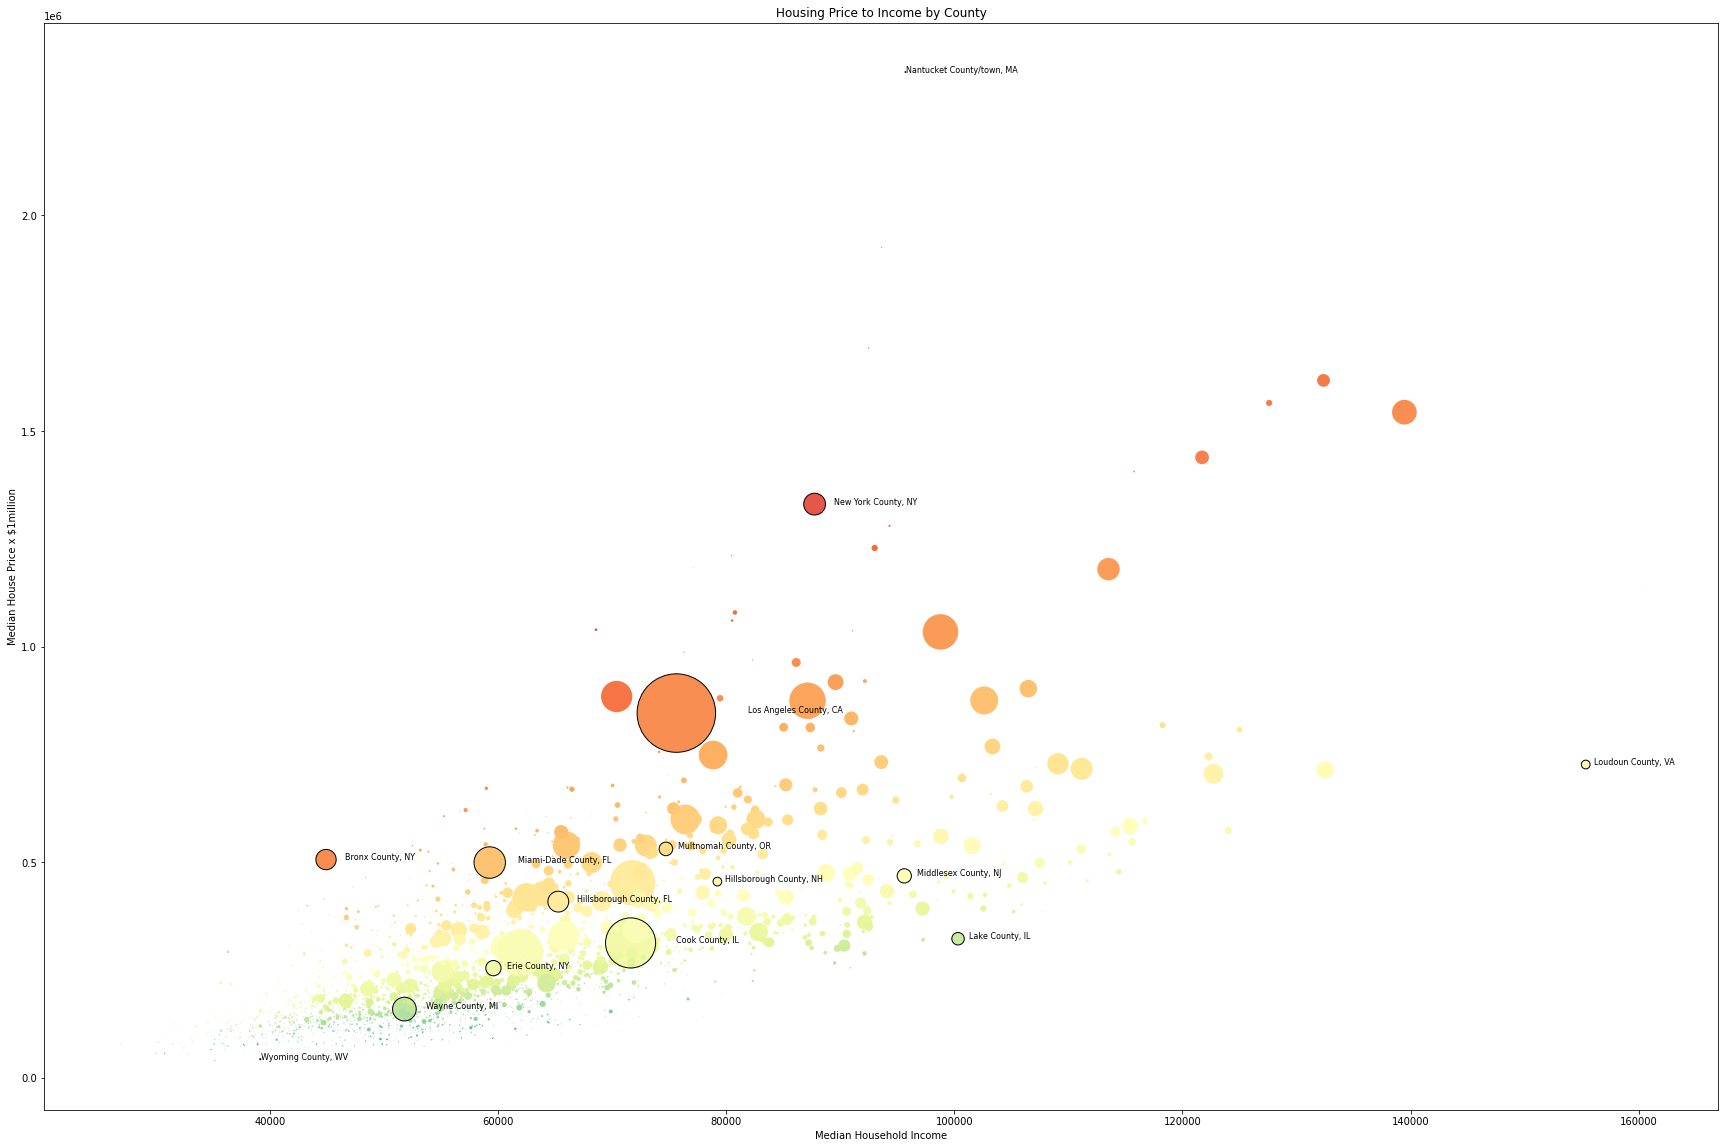

In [ ]:
#Calculate value arrays to use for colors and sizes
colors = merged2["Price_Income_Ratio"].apply(lambda x: math.log((1/x)))
sizes = (merged2["Population"])**1.4/1000000

#Create initial graph
plt.rcParams["figure.figsize"] = (30,20)
plt.scatter(merged2['Income'], merged2['House_Price'], c=colors, cmap='Spectral', s=sizes, edgecolors="None")
plt.xlabel('Median Household Income')
plt.ylabel('Median House Price x $1million')
plt.title('Housing Price to Income by County')

#Add selected counties to list after a validity check
county_list = []
county_names = ['Los Angeles County, CA', 'Cook County, IL', 'Lake County, IL', 'Middlesex County, NJ', 'New York County, NY', 'Miami-Dade County, FL',   'Wayne County, MI', 'Hillsborough County, FL',  'Bronx County, NY', 'Hillsborough County, NH', 'Loudoun County, VA', 'Erie County, NY', 'Multnomah County, OR', 'Nantucket County/town, MA', 'Wyoming County, WV']
for row in merged2.index: 
    if merged2.iloc[row]["Area_name"] in county_names:
        county_list.append(row)
        
#Highlight selected counties
for i in county_list:
    plt.annotate(merged2.iloc[i]['Area_name'], (merged2.iloc[i]['Income']+(math.sqrt(sizes[i])*80), merged2.iloc[i]['House_Price']+math.sqrt(sizes[i])*20), fontsize=8)
    plt.scatter(merged2.iloc[i]['Income'], merged2.iloc[i]['House_Price'], s=sizes[i], c='None', edgecolor='black')

plt.savefig('Price_to_Income_scatter1.png')


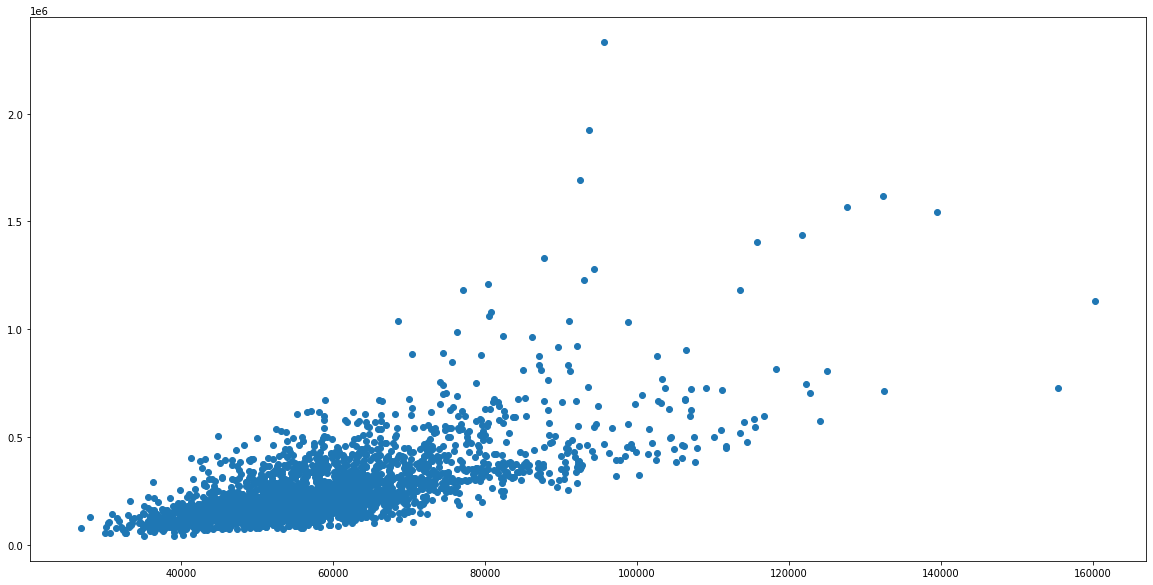

In [ ]:


#plt.scatter(merged["Labor_Force"], merged["Price_Income_Ratio"],  c=colors, cmap='Spectral', s=sizes)
#plt.xscale('log')
#plt.yscale('linear')
#for i in t:
#    plt.annotate(merged.iloc[i]['Area_name'], (merged.iloc[i]['Income']+(math.sqrt(sizes[i])*80), merged.iloc[i]['House_Price']+math.sqrt(sizes[i])*20), fontsize=6)
#    plt.scatter(merged.iloc[i]["Labor_Force"], merged.iloc[i]["Price_Income_Ratio"], s=sizes[i], c='None', edgecolor='black')
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(merged2["Income"], merged2["House_Price"])



Generate Regression Model

In [ ]:
X = merged2[["Income"]]
y = merged2[["House_Price"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X)
#lr.coef_
#lr.intercept_

Plot Regression Model

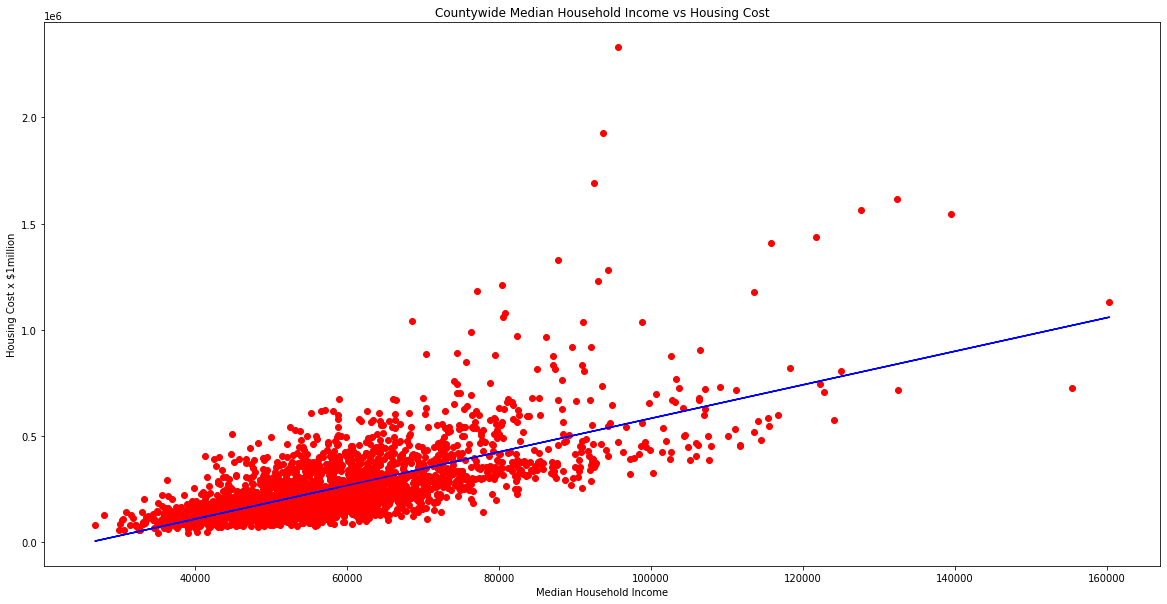

In [ ]:
plt.scatter(X, y, color = 'red')
plt.plot(X, lr.predict(X), color = 'blue')
plt.title('Countywide Median Household Income vs Housing Cost')
plt.xlabel('Median Household Income')
plt.ylabel('Housing Cost x $1million')
plt.show()

Plot Histogram of Price-to-Income Ratios

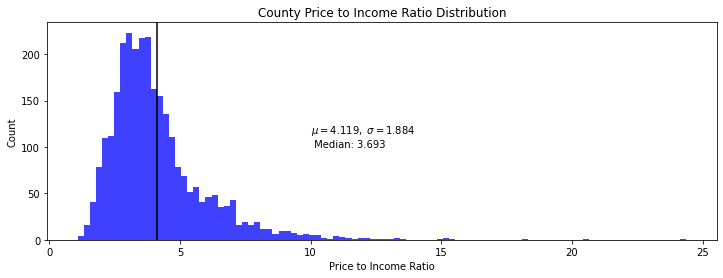

In [ ]:
plt.rcParams["figure.figsize"] = (12,4)

plt.hist(merged2[PIR], 100, facecolor='b', alpha=.75)
#weights=merged["Labor_Force"]

plt.xlabel('Price to Income Ratio')
plt.ylabel('Count')
plt.title('County Price to Income Ratio Distribution')
plt.axvline(PIR_mean, color='black')
#plt.axvline(PIR_50, color='black')
#plt.axvline(PIR_75, color='black')


txt = f'$\mu={PIR_mean:.3f},\ \sigma={PIR_SD:.3f}$\n Median: {PIR_50:.3f}'
plt.text(10, 100, txt)
plt.savefig('PIR.png')
plt.show()

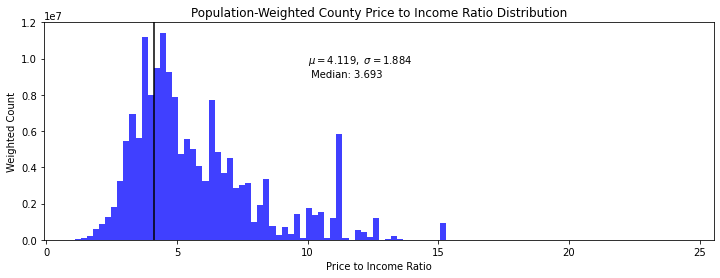

In [ ]:
plt.hist(merged2[PIR], 100, facecolor='b', alpha=.75, weights=merged2["Labor_Force"])


plt.xlabel('Price to Income Ratio')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted County Price to Income Ratio Distribution')
plt.axvline(PIR_mean, color='black')
#plt.axvline(PIR_50, color='black')
#plt.axvline(PIR_75, color='black')
txt = f'$\mu={PIR_mean:.3f},\ \sigma={PIR_SD:.3f}$\n Median: {PIR_50:.3f}'
plt.text(10, 9000000, txt)
plt.savefig('PIR_weighted.png')
plt.show()

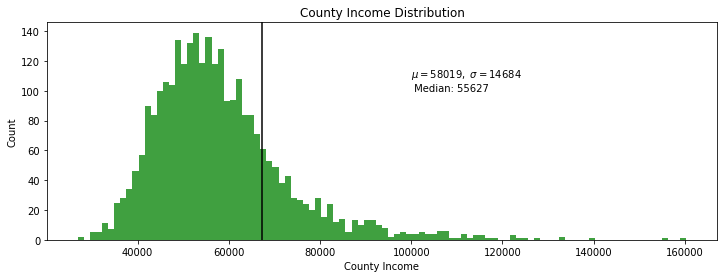

In [ ]:
n, bins, patches = plt.hist(merged2["Income"], 100, facecolor='g', alpha=.75)
plt.xlabel('County Income')
plt.ylabel('Count')
plt.title('County Income Distribution')
plt.axvline(US_MHI, color='black')
txt = f'$\mu={INC_mean:.0f},\ \sigma={INC_SD:.0f}$\n Median: {INC_50:.0f}'
plt.text(100000, 100, txt)
plt.savefig('Income.png')
plt.show()

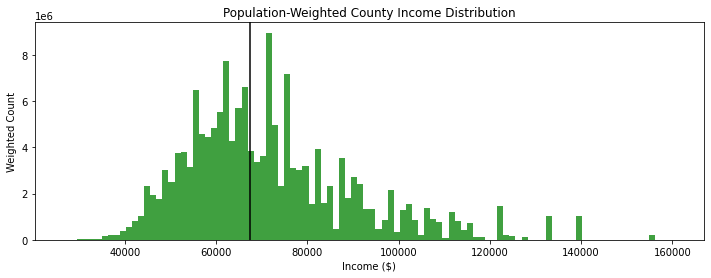

In [ ]:
n, bins, patches = plt.hist(merged2["Income"], 100, facecolor='g', alpha=.75, weights=merged2["Labor_Force"])
plt.xlabel('Income ($)')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted County Income Distribution')
plt.axvline(US_MHI, color='black')
# plt.text(10, .025, r'$\mu=100,\ \sigma=15$')
plt.savefig('Income_weighted.png')
plt.show()

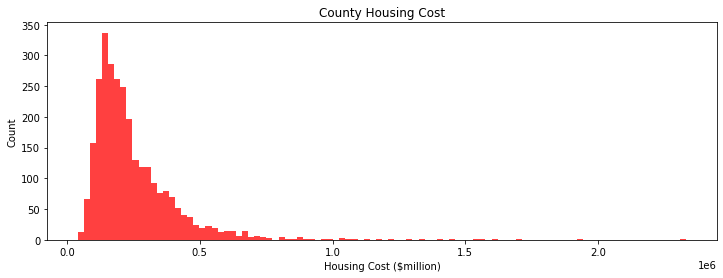

In [ ]:
n, bins, patches = plt.hist(merged2["House_Price"], 100, facecolor='r', alpha=.75)
#plt.set_xticks([100000, 200000, 300000, 400000, 500000])
plt.xlabel('Housing Cost ($million)')
plt.ylabel('Count')
plt.title('County Housing Cost')
plt.savefig('House_cost.png')
plt.show()

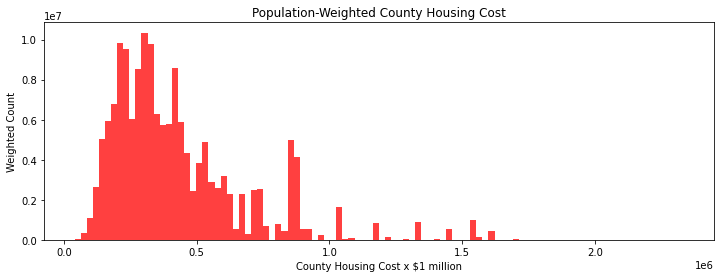

In [ ]:
n, bins, patches = plt.hist(merged2["House_Price"], 100, facecolor='r', alpha=.75, weights=merged2["Labor_Force"])
plt.xlabel('County Housing Cost x $1 million')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted County Housing Cost')
plt.savefig('House_cost_weighted')
plt.show()